In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loadmydata.load_nyc_taxi import load_nyc_taxi_dataset
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster import hierarchy
from scipy.signal import argrelmax, periodogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

### Load Datas

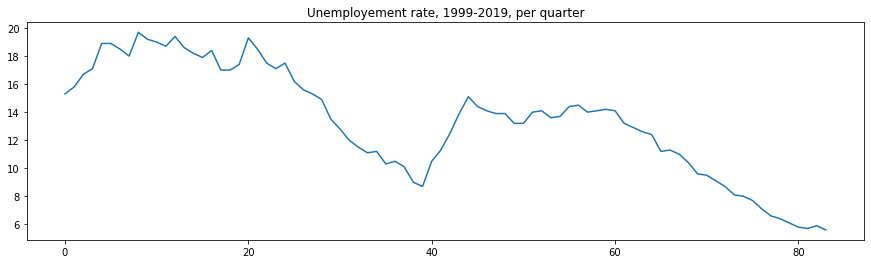

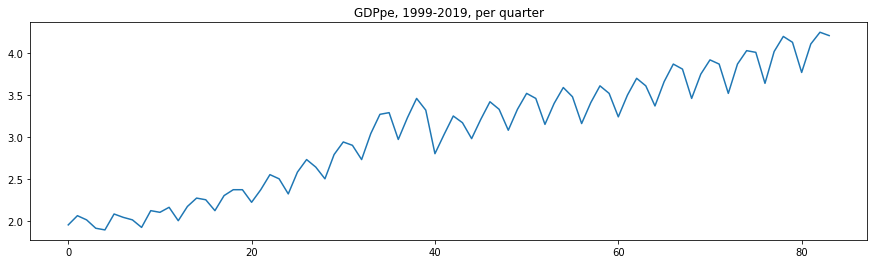

In [7]:
df = pd.read_csv('datas.csv').T
df = df[[1,2]][1:]
UR = df[2].to_numpy()
GDP = df[1].to_numpy()

## We reorder with time : Q4, Q3, Q2, Q1, Q4 ...
n=UR.size//4
for i in range(n):
    UR[4*i], UR[4*i+3] = UR[4*i+3], UR[4*i]
    UR[4*i+1], UR[4*i+2] = UR[4*i+2], UR[4*i+1]
    GDP[4*i], GDP[4*i+3] = GDP[4*i+3], GDP[4*i]
    GDP[4*i+1], GDP[4*i+2] = GDP[4*i+2], GDP[4*i+1]

for i in range(4*n):
    UR[i]=UR[i].replace(',', '.')
    GDP[i]=GDP[i].replace(',', '.')

UR = UR.astype(np.float)[::-1] 
GDP = GDP.astype(np.float)[::-1]

def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

fig, ax = fig_ax()
plt.title("Unemployement rate, 1999-2019, per quarter")
ax.plot([i for i in range(len(UR))], UR)

fig, ax = fig_ax()
plt.title("GDPpe, 1999-2019, per quarter")
ax.plot([i for i in range(len(GDP))], GDP)


# I) Reproduction of the results

## 1) Fit GDP SARIMA

The authors actually describe what we know as the SARIMA model. An introduction to the python modules that can be used can be found at : https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

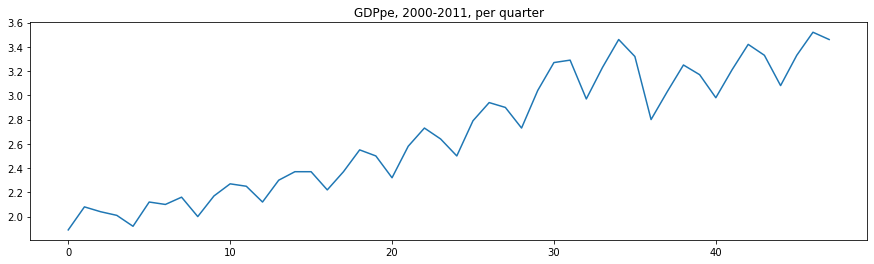

In [100]:
#extraction des données de l'article
gdp = GDP[4:-32]

fig, ax = fig_ax()
plt.title("GDPpe, 2000-2011, per quarter")
ax.plot([i for i in range(len(gdp))], gdp)

Let us start by reproducting their GDPpe results that will be more commonly called GDP. The next blocks show that:

- Logic and the PACF give us s=4.

- GDP do not benefit from the stationarity property as the Augmented Dickey-Fuller test do not permit to refute the null hypothesis

- PACF seems to give us d=D=1

- $z_t=(1-B)(1-B^4)GDPt$ is stationary while $(1-B)GDPt$ is not at threshold 1%

- $z_t$ depends mainly on $z_{t-4}$ which leads to $p=0$, $P=1$.


ADF Statistic: -0.41222388753647227
p-value: 0.9080377328658321


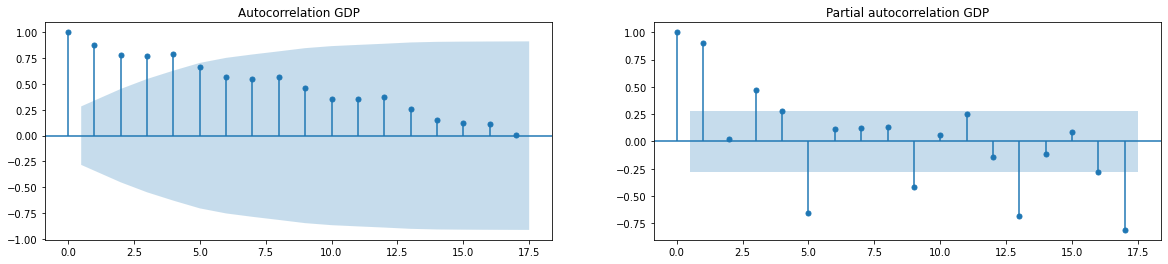

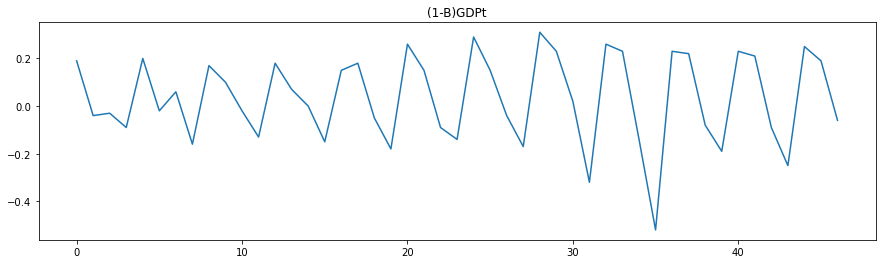

ADF Statistic: -3.2482944501445097
p-value: 0.017353957952695436


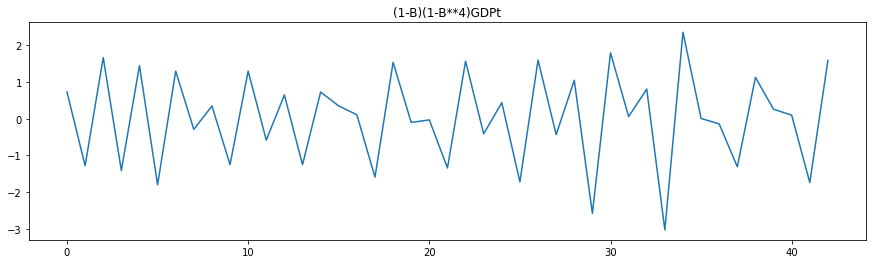

ADF Statistic: -4.580890578688619
p-value: 0.00014006087010199163


/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


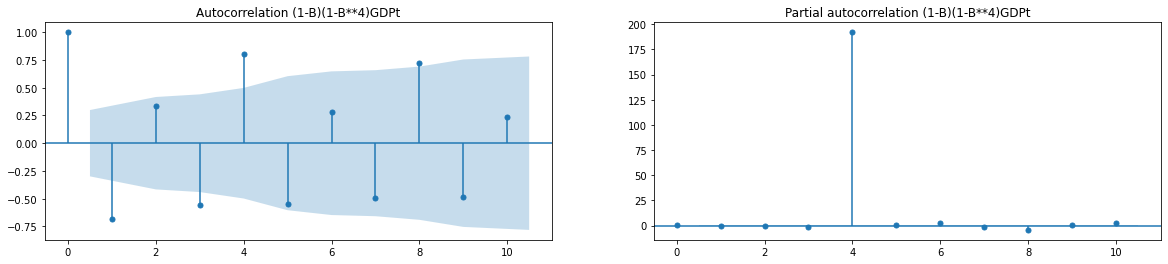

In [101]:
gdp = GDP[4:-32]
#gdp = np.log(GDP[4:-32])

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(gdp, ax=ax_0, title="Autocorrelation GDP")
_ = plot_pacf(gdp, ax=ax_1, title="Partial autocorrelation GDP")


##see if GDBt is stationary
ad_fuller_result = adfuller(gdp)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


##see if (1-B)(GDBt) is stationary
gdp = np.diff(gdp)

plt.figure(figsize=[15, 4]);
plt.plot(gdp)
plt.title("(1-B)GDPt")
plt.show()

ad_fuller_result = adfuller(gdp)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

##see if (1-B)(1-B**4)GDPt is stationary
gdp = np.diff(gdp, n=4)

plt.figure(figsize=[15, 4]); 
plt.plot(gdp)
plt.title("(1-B)(1-B**4)GDPt")
plt.show()

ad_fuller_result = adfuller(gdp)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

##show that p=0, P=1
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(gdp, ax=ax_0, title="Autocorrelation (1-B)(1-B**4)GDPt", lags=10)
_ = plot_pacf(gdp, ax=ax_1, title="Partial autocorrelation (1-B)(1-B**4)GDPt", lags=10)

At this point, it is not obvious why the authors chose $q=Q=0$ as the acf plot could make us choose $q=1$ (and even maybe $Q=1$). What we will do is thus fit a $SARIMA(0,1,0)(1,1,0)$ and check the autocorrelations afterwards to see if not noise as to be taken into account.

Note that applying the previous steps to $gdp = log(GDP[4:-32])$ yields the exact same conclusion as to which model to choose. As it is quite unclear in the article if they applied the log or not, it is fortunate that our conclusions do not differ either way. 

By accepting the choice of model of the authors, our SARIMA(0,1,0)(1,1,0) fits to $(1-B)(1-B^4)(1+0.2969(std :0.094) B^4)GDPpe_t = a_t$. Whether the authors choose to apply this model to log(GDP) or to GDP, the parameters we obtain are in phase with those of the paper :

In [264]:
gdp = GDP[4:-32]
article_model = SARIMAX(gdp, order=(0, 1, 0), seasonal_order=(1, 1, 0, 4)).fit()
print(article_model.summary())

article_model_log = SARIMAX(np.log(gdp), order=(0, 1, 0), seasonal_order=(1, 1, 0, 4)).fit()
print(article_model_log.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  48.164
Date:                           Thu, 25 Mar 2021   AIC                            -92.327
Time:                                   10:52:08   BIC                            -88.805
Sample:                                        0   HQIC                           -91.029
                                            - 48                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4       -0.2969      0.094     -3.159      0.002      -0.481      -0.113
sigma2         0.0062      0.001      7.384

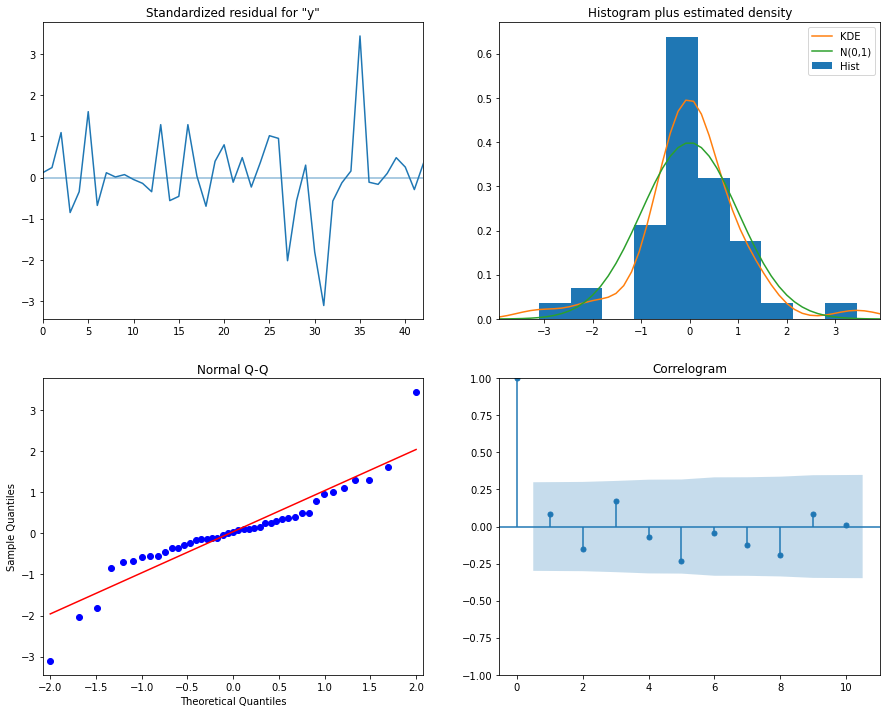

In [91]:
article_model.plot_diagnostics(figsize=(15,12));

The correlogram is satisfactory and we do not need to change q or Q. We can visually see the prediction and assert that they seem well-founded. The model given by the authors for GDP is conclusive.

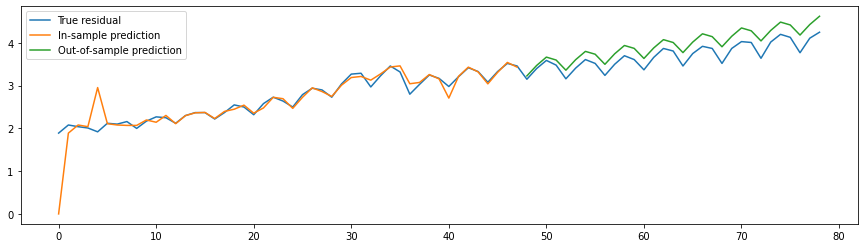

In [98]:
SCOPE = 31

in_sample_pred = article_model.predict()
out_sample_pred = article_model.forecast(SCOPE)

fig, ax = fig_ax()
ax.plot([i for i in range(len(gdp)+SCOPE)], GDP[4:-32+SCOPE], label="True residual")
ax.plot([i for i in range(len(gdp))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(gdp),len(gdp)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

## 2) Fit UR SARIMA

The next blocks show that :

- Logic gives us again s=4.


- UR do not benefit from the stationarity property as the Augmented Dickey-Fuller test do not permit to refute the null hypothesis


- contrary to what the article claims, the data obtained for the period $[2000,2012]$ are not sufficient to affirm that $(1-B)UR_t$ is stationnary. Our first guest would have been to take $(1-B^4)UR_t$ which is stationnary according to the test. Even accepting this hypothesis, checking the acf and pacf for $(1-B)UR_t$, it is not obvious at all how the authors conluded that $SARIMA(0,1,1)(2,0,0)$ would be a good fit.


- Following the same reasonning as with GDP, we could have choosen $SARIMA(1,0,1)(1,1,0)$


- However the extended data taken over the period $[1999,2019]$ do not allow us to refute the hypothesis that $(1-B)UR_t$ is stationnary at threshold 5% and also render $SARIMA(0,1,1)(2,0,0)$ a plausible model. How the authors constructed this model with the datas they had remains a mystery. In the following we will thus keep both models to see which one fits better.


- Finally, the two models yields satisfactory correlograms. It hints that the authors tried several model and chose this one based on AIC minimization and correlograms considerations.

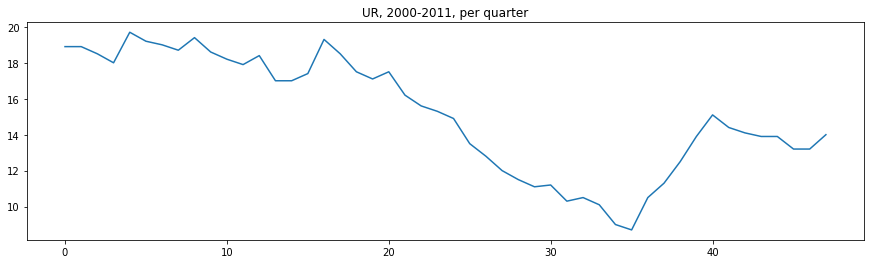


Reasonning from datas accessible at the article written time :

ADF Statistic: -1.8524711954019137
p-value: 0.3547395778865736


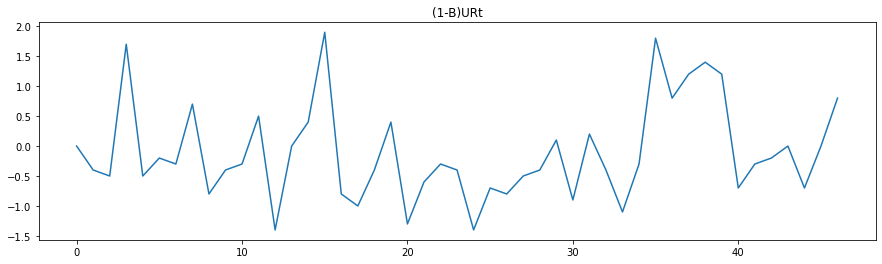

ADF Statistic: -2.158903626105008
p-value: 0.2214975748881618


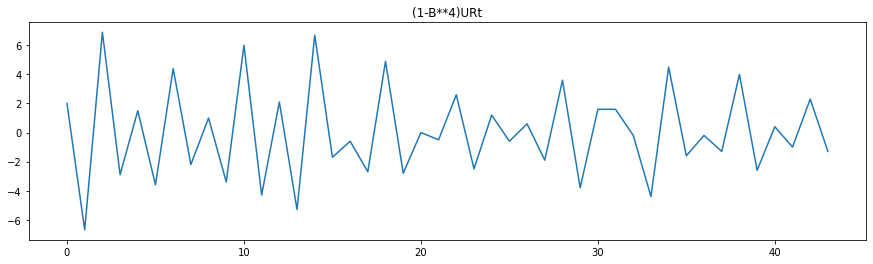

ADF Statistic: -3.0509339143968766
p-value: 0.030403892039647832

Reasonning from complete datas :



/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


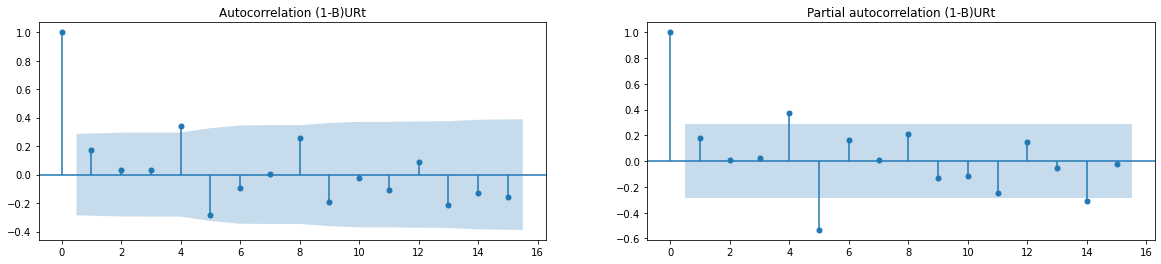

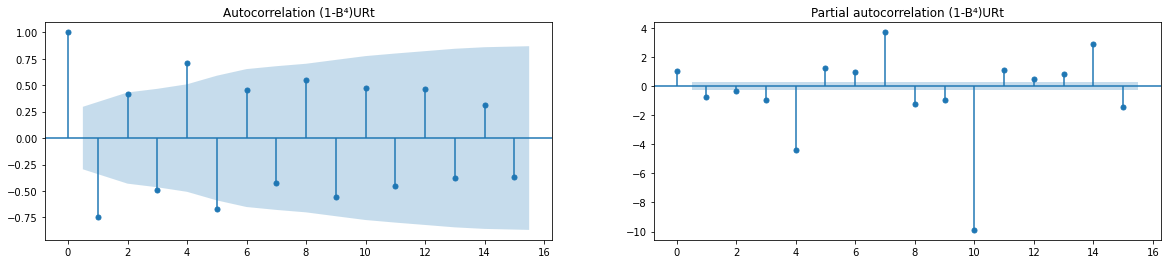

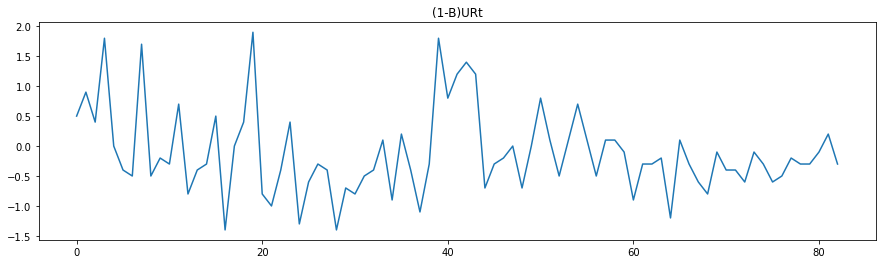

ADF Statistic: -2.9171607324011433
p-value: 0.04338852153335665


/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


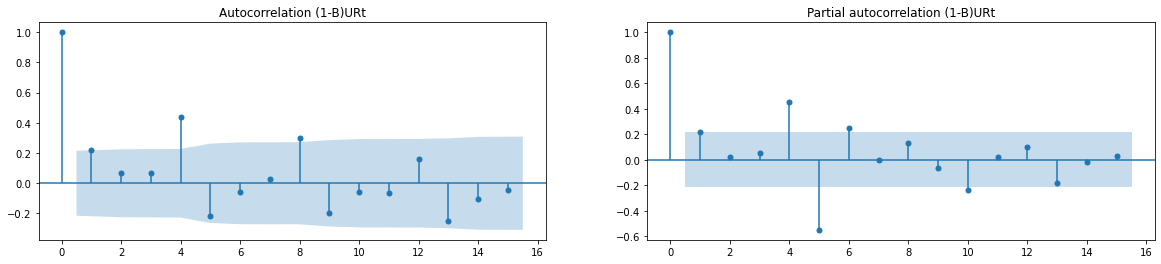

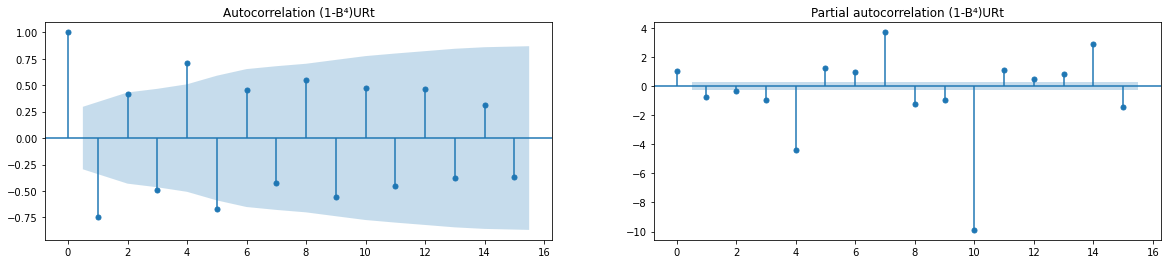

In [144]:
#extraction des données de l'article
ur = UR[4:-32]

fig, ax = fig_ax()
plt.title("UR, 2000-2011, per quarter")
ax.plot([i for i in range(len(ur))], ur)
plt.show()

print("")
print("Reasonning from datas accessible at the article written time :")
print("")

ad_fuller_result = adfuller(ur)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


##see if (1-B)URt is stationary
ur = np.diff(ur)
ur_author = ur

plt.figure(figsize=[15, 4]);
plt.plot(ur)
plt.title("(1-B)URt")
plt.show()

ad_fuller_result = adfuller(ur)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

##see if (1-B⁴)URt is stationary
ur = UR[4:-32]
ur = np.diff(ur, n=4)
ur_test = ur

plt.figure(figsize=[15, 4]);
plt.plot(ur)
plt.title("(1-B**4)URt")
plt.show()

ad_fuller_result = adfuller(ur)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ur_author, ax=ax_0, title="Autocorrelation (1-B)URt", lags=15)
_ = plot_pacf(ur_author, ax=ax_1, title="Partial autocorrelation (1-B)URt", lags=15)

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ur_test, ax=ax_0, title="Autocorrelation (1-B⁴)URt", lags=15)
_ = plot_pacf(ur_test, ax=ax_1, title="Partial autocorrelation (1-B⁴)URt", lags=15)

print("")
print("Reasonning from complete datas :")
print("")
##see if (1-B)URt is stationary on extended period
ur = UR
ur = np.diff(ur)
ur_author = ur

plt.figure(figsize=[15, 4]);
plt.plot(ur)
plt.title("(1-B)URt")
plt.show()

ad_fuller_result = adfuller(ur)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ur_author, ax=ax_0, title="Autocorrelation (1-B)URt", lags=15)
_ = plot_pacf(ur_author, ax=ax_1, title="Partial autocorrelation (1-B)URt", lags=15)

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ur_test, ax=ax_0, title="Autocorrelation (1-B⁴)URt", lags=15)
_ = plot_pacf(ur_test, ax=ax_1, title="Partial autocorrelation (1-B⁴)URt", lags=15)


In [161]:
ur = UR[4:-32]

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 4)   Log Likelihood                 -47.989
Date:                            Thu, 25 Mar 2021   AIC                            103.979
Time:                                    09:27:52   BIC                            111.379
Sample:                                         0   HQIC                           106.764
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5357      0.136      3.932      0.000       0.269       0.803
ar.S.L4        0.5096      0.142   

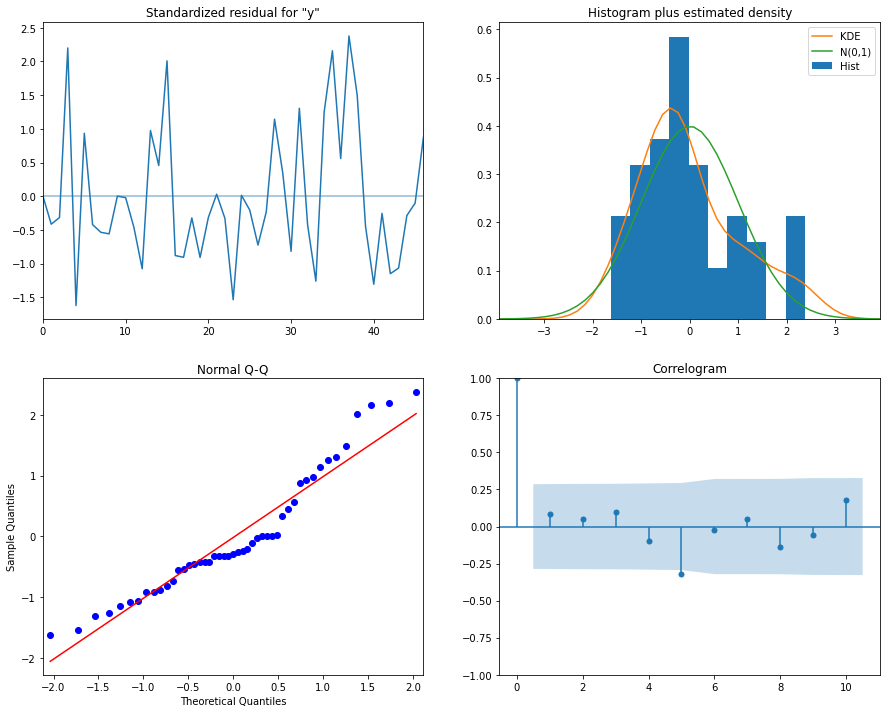

In [166]:
article_model = SARIMAX(ur, order=(0, 1, 1), seasonal_order=(2, 0, 0, 4)).fit()
article_model.plot_diagnostics(figsize=(15,12))
print(article_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 4)   Log Likelihood                 -43.529
Date:                            Thu, 25 Mar 2021   AIC                             95.059
Time:                                    09:28:03   BIC                            102.195
Sample:                                         0   HQIC                            97.705
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8574      0.087      9.815      0.000       0.686       1.029
ma.L1          0.7475      0.125   

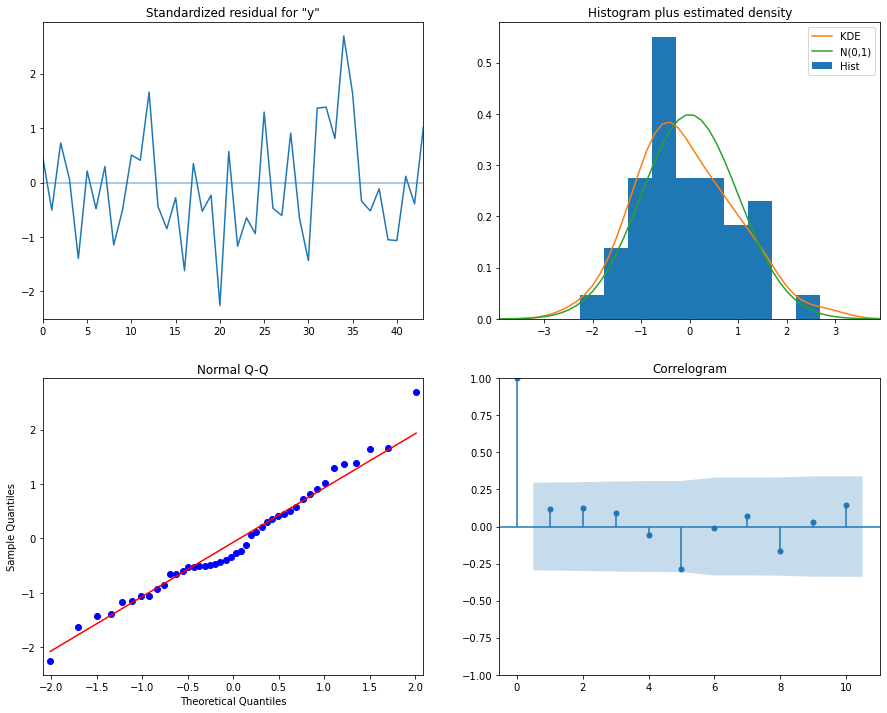

In [167]:
alternate_model = SARIMAX(ur, order=(1, 0, 1), seasonal_order=(1, 1, 0, 4)).fit()
print(alternate_model.summary())
alternate_model.plot_diagnostics(figsize=(15,12));

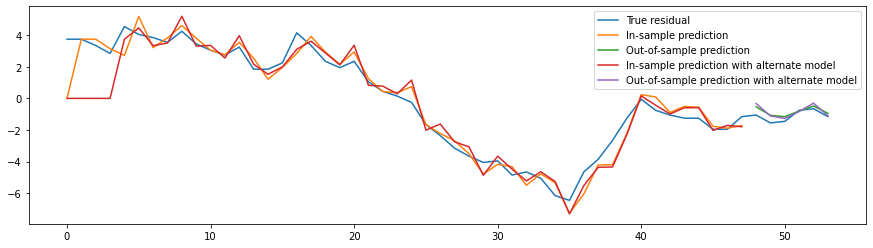

In [179]:
SCOPE = 6

in_sample_pred = article_model.predict()
out_sample_pred = article_model.forecast(SCOPE)

in_sample_pred2 = alternate_model.predict()
out_sample_pred2 = alternate_model.forecast(SCOPE)

fig, ax = fig_ax()
ax.plot([i for i in range(len(ur)+SCOPE)], UR[4:-32+SCOPE], label="True residual")
ax.plot([i for i in range(len(ur))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(ur),len(ur)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
ax.plot([i for i in range(len(ur))], in_sample_pred2, label="In-sample prediction with alternate model")
ax.plot([i for i in range(len(ur),len(ur)+SCOPE)], out_sample_pred2, label="Out-of-sample prediction with alternate model")
_ = plt.legend()

Both model yield the same performance when considering small SCOPE of predictions. For the remaining of this project, we will thus continue with the model from the article as to minimize risks of decoherence.

## 3) Transfert function

In [180]:
forecast_UR = out_sample_pred
forecast_UR

array([-0.53210027, -1.07505249, -1.15485405, -0.80034245, -0.48331204,
       -0.94622629])

In [169]:
gdp = GDP[4:-32]
ur = UR[4:-32]

GDP-= gdp.mean()
UR-=ur.mean()
model = SARIMAX(gdp, exog = ur,order=(0, 0, 1), seasonal_order=(0, 0, 1, 4)).fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   48
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 4)   Log Likelihood                  24.026
Date:                           Thu, 25 Mar 2021   AIC                            -40.052
Time:                                   09:29:12   BIC                            -32.567
Sample:                                        0   HQIC                           -37.223
                                            - 48                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1233      0.017     -7.052      0.000      -0.158      -0.089
ma.L1          0.7899      0.087      9.081

/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


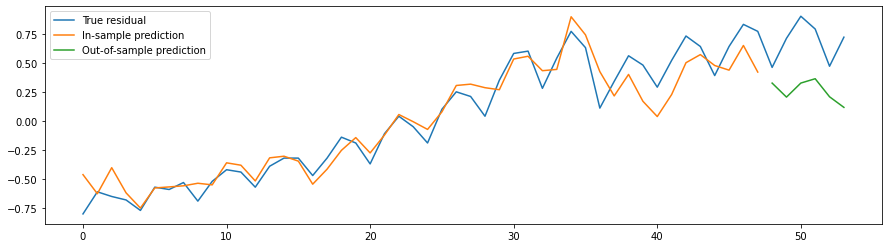

In [182]:
SCOPE = 6

in_sample_pred = model.predict()
out_sample_pred = model.forecast(SCOPE, exog=forecast_UR)

fig, ax = fig_ax()
ax.plot([i for i in range(len(gdp)+SCOPE)], GDP[4:-32+SCOPE], label="True residual")
ax.plot([i for i in range(len(gdp))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(gdp),len(gdp)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()


We find the same parameters than the article and also conclude that using a transfer function that way is not very effective. Especially, we use a scope of 6 here but with a higher scope, this model is even worse.

# II) Critique

However our conclusion differ : we do not agree that ARIMA is always more accurate than ARIMAX. It is certainly the case here, with the given orders for the transfert function but it is quite obious that it is not always the case. A trivial example would be to take a simple electrical system composed of an alternative generator and a bulb working effectively as a resistance of known parameter R. Assume our tools are such that we can measure voltage with a very good precision while intensity is measured poorly. Then it makes sense to extrapolate data from U(t) and then use a transfer function I(t)=U(t)/R.

A better approach to those results would be to understand why that model do not yield great results. By taking this model, the authors assumed an underlying linear dependancie between those two series. While stating that decreasing GDP leads to let down and thus UR increasing, it is by no way clear why the dependencie would be linear.

## 1)Using VARIMA

/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Statespace Model Results                           
Dep. Variable:          ['gdp', 'ur']   No. Observations:                   48
Model:                         VAR(5)   Log Likelihood                  19.079
                          + intercept   AIC                             11.842
Date:                Thu, 25 Mar 2021   BIC                             58.622
Time:                        11:22:47   HQIC                            29.521
Sample:                             0                                         
                                 - 48                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.06, 0.11   Jarque-Bera (JB):          1.04, 17.89
Prob(Q):                        0.80, 0.74   Prob(JB):                   0.60, 0.00
Heteroskedasticity (H):         2.60, 1.14   Skew:                      -0.12, 0.87
Prob(H) (two-sided):            0.07,

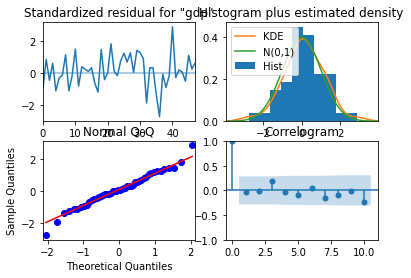

/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [305]:
## schift UR of 1 to be able to use it to predict GDP
l = list()
l.append(0.0)
for i in range(len(UR)-1):
    l.append(UR[i])
L= np.array(l)

gdp = GDP[4:-32]
ur = UR[4:-32]
l = L[4:-32]

def VARMAX_wrapper(ur, gdp, display=True):
    concat = np.concatenate((gdp.reshape(len(gdp),1),ur.reshape(len(ur),1)),axis=1)
    df = pd.DataFrame(data=concat, columns=["gdp", "ur"])

    mod = sm.tsa.VARMAX(df[['gdp', 'ur']], order=(5, 0, 1))
    res = mod.fit(maxiter=2000, disp=False)
    if(display):
        print(res.summary())
        res.plot_diagnostics();plt.show()
    return res
res = VARMAX_wrapper(ur, gdp)
res2 = VARMAX_wrapper(l, gdp, display=False)

/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/obker/Downloads/yes/envs/ast/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


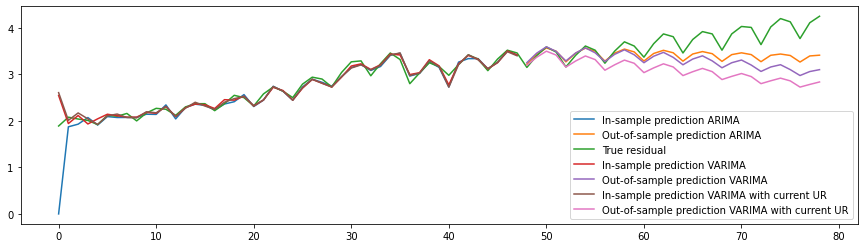

In [306]:
SCOPE = 31

#article_model = SARIMAX(gdp, order=(0, 1, 0), seasonal_order=(1, 1, 0, 4)).fit()
article_model = SARIMAX(gdp, order=(5, 0, 1)).fit()

in_sample_pred = res.predict()
out_sample_pred = res.forecast(SCOPE)

in_sample_pred2 = res2.predict()
out_sample_pred2 = res2.forecast(SCOPE)


in_sample_pred_arima = article_model.predict()
out_sample_pred_arima = article_model.forecast(SCOPE)

fig, ax = fig_ax()
ax.plot([i for i in range(len(gdp))], in_sample_pred_arima, label="In-sample prediction ARIMA")
ax.plot([i for i in range(len(gdp),len(gdp)+SCOPE)], out_sample_pred_arima, label="Out-of-sample prediction ARIMA")


ax.plot([i for i in range(len(gdp)+SCOPE)], GDP[4:-32+SCOPE], label="True residual")
ax.plot([i for i in range(len(gdp))], in_sample_pred['gdp'], label="In-sample prediction VARIMA")
ax.plot([i for i in range(len(gdp),len(gdp)+SCOPE)], out_sample_pred['gdp'], label="Out-of-sample prediction VARIMA")
ax.plot([i for i in range(len(gdp))], in_sample_pred2['gdp'], label="In-sample prediction VARIMA with current UR")
ax.plot([i for i in range(len(gdp),len(gdp)+SCOPE)], out_sample_pred2['gdp'], label="Out-of-sample prediction VARIMA with current UR")
_ = plt.legend()

Using VARIMA shows that for a 3 year range of prediction, knowing UR is actually detrimental to predict GDP. Which means that even though the tendancies of the two functions can be predicted from one another, knowing previous UR and even the current UR is not helpful compared to using just previous GDP. 

## 2) Conclusion

This is understandable because on the period of time at hands, the 2008 crisis encompass 1/4 of our data and is caracterized by a huge voloatility in UR and numerous rupture. GDP on the other hand is not that volatile and keeps a somehow steady trend. 

That means that the intrisic idea of using UR to predict GDP and hoping to have better results than ARIMA was flawed. That does not mean that ARIMA is better than ARIMAX on all use cases.

# Show that UR could not predict well GPC

We will show that there is a flaw in the method : that the UR had less expressive power than GPC, then ARIMAX was bounded to be less precise than ARIMA.

For this we will train a LSTM to predict GPC from GPC or UR, and show that even using the same tecnic there will be a difference of performance

In [12]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


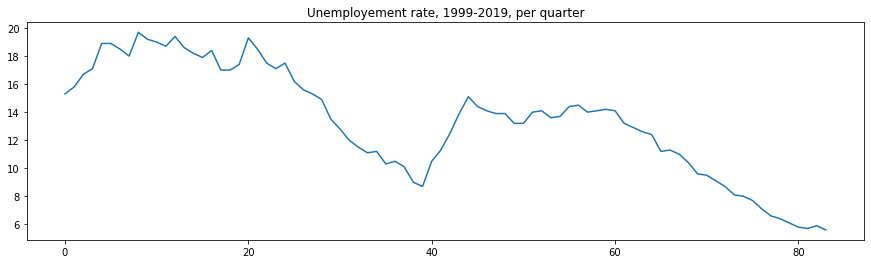

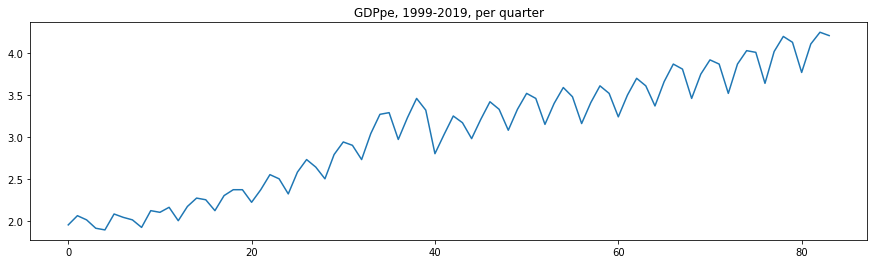

In [3]:
df = pd.read_csv('datas.csv').T
df = df[[1,2]][1:]
UR = df[2].to_numpy()
GDP = df[1].to_numpy()

## We reorder with time : Q4, Q3, Q2, Q1, Q4 ...
n=UR.size//4
for i in range(n):
    UR[4*i], UR[4*i+3] = UR[4*i+3], UR[4*i]
    UR[4*i+1], UR[4*i+2] = UR[4*i+2], UR[4*i+1]
    GDP[4*i], GDP[4*i+3] = GDP[4*i+3], GDP[4*i]
    GDP[4*i+1], GDP[4*i+2] = GDP[4*i+2], GDP[4*i+1]

for i in range(4*n):
    UR[i]=UR[i].replace(',', '.')
    GDP[i]=GDP[i].replace(',', '.')

UR = UR.astype(np.float)[::-1] 
GDP = GDP.astype(np.float)[::-1]

def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

fig, ax = fig_ax()
plt.title("Unemployement rate, 1999-2019, per quarter")
ax.plot([i for i in range(len(UR))], UR)

fig, ax = fig_ax()
plt.title("GDPpe, 1999-2019, per quarter")
ax.plot([i for i in range(len(GDP))], GDP)


## Data preprocessing

We create the training dataset

In [70]:
train_window = 8

train_ur, test_ur = UR[:-2*train_window], UR[-2*train_window-1:]
train_gdp, test_gdp = GDP[:-2*train_window-1], GDP[-2*train_window:]


scaler = MinMaxScaler(feature_range=(-1, 1))
train_ur_normalized = scaler.fit_transform(train_ur.reshape(-1, 1))
test_ur_normalized = scaler.transform(test_ur.reshape(-1, 1))
train_gdp_normalized = scaler.fit_transform(train_gdp.reshape(-1, 1))
test_gdp_normalized = scaler.transform(test_gdp.reshape(-1, 1))
train_ur_normalized = torch.FloatTensor(train_ur_normalized).view(-1)
test_ur_normalized = torch.FloatTensor(test_ur_normalized).view(-1)
train_gdp_normalized = torch.FloatTensor(train_gdp_normalized).view(-1)
test_gdp_normalized = torch.FloatTensor(test_gdp_normalized).view(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_ur_inout_seq = create_inout_sequences(train_ur_normalized, train_window)
test_ur_inout_seq = create_inout_sequences(test_ur_normalized, train_window)
train_gdp_inout_seq = create_inout_sequences(train_gdp_normalized, train_window) 
test_gdp_inout_seq = create_inout_sequences(test_gdp_normalized, train_window)

## Defining the LSTM model

In [96]:
torch.manual_seed(42)

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model_ur = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_ur.parameters(), lr=0.001)

## Training the model

  1%|          | 1/150 [00:00<00:56,  2.65it/s]

Test dataset : epoch 0 loss = 1.388858715693156
Train dataset :epoch:   0 loss: 0.27776310568769985


 17%|█▋        | 26/150 [00:09<00:50,  2.46it/s]

Test dataset : epoch 25 loss = 0.15849699659479988
Train dataset :epoch:  25 loss: 0.01903989462851238


 34%|███▍      | 51/150 [00:19<00:37,  2.66it/s]

Test dataset : epoch 50 loss = 0.2319241240620613
Train dataset :epoch:  50 loss: 0.017258686444044238


 51%|█████     | 76/150 [00:29<00:31,  2.32it/s]

Test dataset : epoch 75 loss = 0.08884959647225009
Train dataset :epoch:  75 loss: 0.014368245793351282


 67%|██████▋   | 101/150 [00:40<00:23,  2.11it/s]

Test dataset : epoch 100 loss = 0.13517838675114843
Train dataset :epoch: 100 loss: 0.009126439307116622


 84%|████████▍ | 126/150 [00:52<00:11,  2.03it/s]

Test dataset : epoch 125 loss = 0.2930002518826061
Train dataset :epoch: 125 loss: 0.008875635436212784


100%|██████████| 150/150 [01:03<00:00,  2.37it/s]


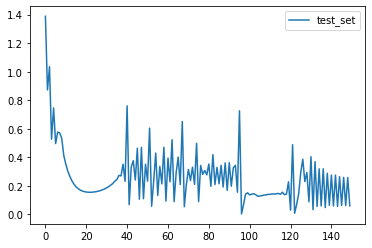

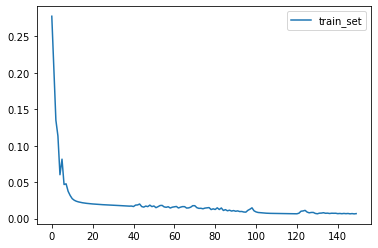

UR LSTM model
Final test loss : 0.002004984706622458, Final_train_loss : 0.006370257389691384


In [97]:
from tqdm import tqdm


def train(model,train_set,test_set,loss_fun,optimizer,epochs):
    list_losses_ur_train = list()
    list_losses_ur_test = list()
    for i in tqdm(range(epochs)):
        train_loss = list()
        for seq, labels in train_set:
            model.train()
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_fun(y_pred, labels)
            train_loss.append(single_loss.item())
            single_loss.backward()
            optimizer.step()
        list_losses_ur_train.append(np.mean(train_loss))

        # Evaluation
        model.eval()
        test_loss = list()
        for seq, labels in test_set:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_fun(y_pred, labels)
            test_loss.append(single_loss.item())
        list_losses_ur_test.append(np.mean(test_loss))
        if i%25 == 0:
            print(f"Test dataset : epoch {i} loss = {np.mean(test_loss)}")
            print(f"Train dataset :epoch: {i:3} loss: {np.mean(train_loss)}")

    plt.plot(list_losses_ur_test,label='test_set')
    plt.legend()
    plt.show()
    plt.plot(list_losses_ur_train,label='train_set')
    plt.legend()
    plt.show()
    return list_losses_ur_test,list_losses_ur_train


epochs = 150
list_test_loss, list_train_loss = train(model_ur,train_ur_inout_seq,
                                          test_ur_inout_seq,loss_function,
                                          optimizer,epochs)
print("UR LSTM model")
print(f"Minimum test loss : {np.min(list_test_loss)}, Minimum_train_loss : {np.min(list_train_loss)}")

# Try prediction with "transfer function" model

In [106]:
train_window = 4

def create_cross_model(input_data_features,input_data_target, tw):
    inout_seq = []
    L = len(input_data_features)
    for i in range(L-tw-1):
        train_seq = input_data_features[i:i+tw]
        train_label = input_data_target[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_ur_cross_seq = create_cross_model(train_ur_normalized,
                                            train_gdp_normalized,
                                            train_window)
test_ur_cross_seq = create_cross_model(test_ur_normalized,
                                           test_gdp_normalized,
                                           train_window)

torch.manual_seed(42)

model_ur_cross = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_ur_cross.parameters(), lr=0.0001)
epochs = 60

  2%|▏         | 1/60 [00:00<00:15,  3.73it/s]

Test dataset : epoch 0 loss = 1.1002386212348938
Train dataset :epoch:   0 loss: 0.33372924371637747


 43%|████▎     | 26/60 [00:07<00:09,  3.45it/s]

Test dataset : epoch 25 loss = 0.2762010459943364
Train dataset :epoch:  25 loss: 0.09634935111812194


 85%|████████▌ | 51/60 [00:14<00:02,  3.11it/s]

Test dataset : epoch 50 loss = 0.40249611840893823
Train dataset :epoch:  50 loss: 0.09150771543384523


100%|██████████| 60/60 [00:17<00:00,  3.42it/s]


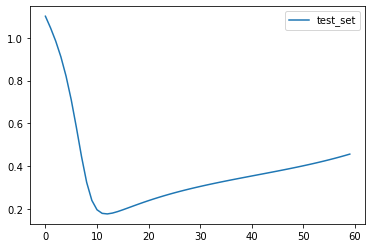

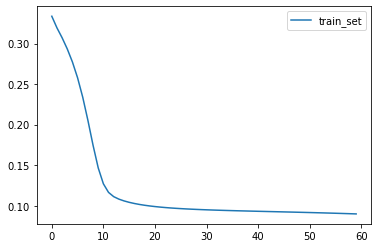

Minimum test loss : 0.17784658982418478, Minimum_train_loss : 0.08981419444852878


In [107]:
list_test_loss, list_train_loss = train(model_ur_cross,train_ur_cross_seq,
                                          test_ur_cross_seq,loss_function,
                                          optimizer,epochs)
print(f"Minimum test loss : {np.min(list_test_loss)}, Minimum_train_loss : {np.min(list_train_loss)}")

  0%|          | 1/225 [00:00<00:58,  3.85it/s]

Test dataset : epoch 0 loss = 0.4411179991438985
Train dataset :epoch:   0 loss: 0.2716893881568842


 12%|█▏        | 26/225 [00:07<00:55,  3.58it/s]

Test dataset : epoch 25 loss = 0.06191189115634188
Train dataset :epoch:  25 loss: 0.03038237005995821


 23%|██▎       | 51/225 [00:14<00:53,  3.23it/s]

Test dataset : epoch 50 loss = 0.004919057199155456
Train dataset :epoch:  50 loss: 0.011200943194593391


 34%|███▍      | 76/225 [00:22<00:43,  3.39it/s]

Test dataset : epoch 75 loss = 0.02239350586993775
Train dataset :epoch:  75 loss: 0.012982694195777243


 45%|████▍     | 101/225 [00:30<00:41,  3.00it/s]

Test dataset : epoch 100 loss = 0.03741227638844672
Train dataset :epoch: 100 loss: 0.006234615079483052


 56%|█████▌    | 126/225 [00:37<00:29,  3.39it/s]

Test dataset : epoch 125 loss = 0.040535451010024794
Train dataset :epoch: 125 loss: 0.004929057798518119


 67%|██████▋   | 151/225 [00:44<00:20,  3.66it/s]

Test dataset : epoch 150 loss = 0.05840232959599234
Train dataset :epoch: 150 loss: 0.00421856239201213


 78%|███████▊  | 176/225 [00:51<00:14,  3.48it/s]

Test dataset : epoch 175 loss = 0.05724241863572388
Train dataset :epoch: 175 loss: 0.003641577220237412


 89%|████████▉ | 201/225 [00:58<00:06,  3.60it/s]

Test dataset : epoch 200 loss = 0.0631124853680376
Train dataset :epoch: 200 loss: 0.0032071269614110834


100%|██████████| 225/225 [01:04<00:00,  3.47it/s]


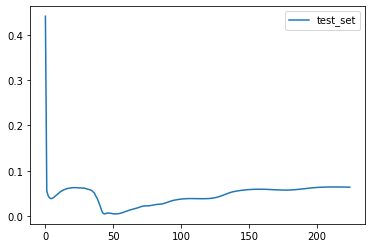

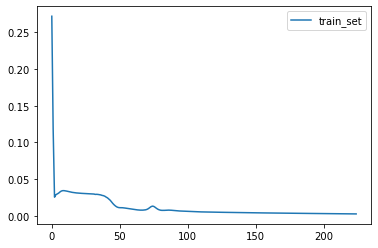

Minimum test loss : 0.004641357431301192, Minimum_train_loss : 0.0027251641916812954


In [101]:
train_window = 4

train_gdp_inout_seq = create_inout_sequences(train_gdp_normalized, train_window) 
test_gdp_inout_seq = create_inout_sequences(test_gdp_normalized, train_window)


torch.manual_seed(42)
model_gdp = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_gdp.parameters(), lr=0.001)
epochs = 225

list_test_loss, list_train_loss = train(model_gdp,train_gdp_inout_seq,
                                          test_gdp_inout_seq,loss_function,
                                          optimizer,epochs)
print(f"Minimum test loss : {np.min(list_test_loss)}, Minimum_train_loss : {np.min(list_train_loss)}")

# A situation where ARIMAX is better than ARIMA

It is easy to design a situation where ARIMA is better than ARIMA, let's try to design two situations where this is the case:

First case : when we observe two linked variables, but one of them is highly noisy and the other one is not. It may be much easier to predict the state of the noisy sequence from the unoisy one (ARIMAX better than ARIMA)

Second case : in the case of hidden model composed of two series, with one model as the hidden state and the other one as the observations. It may be much easier to predict the value of the observations from the hidden state instead of trying to infer it from the previous observations. Also in this case ARIMAX may be better than ARIMA

## First case : two observations among which one is noisy

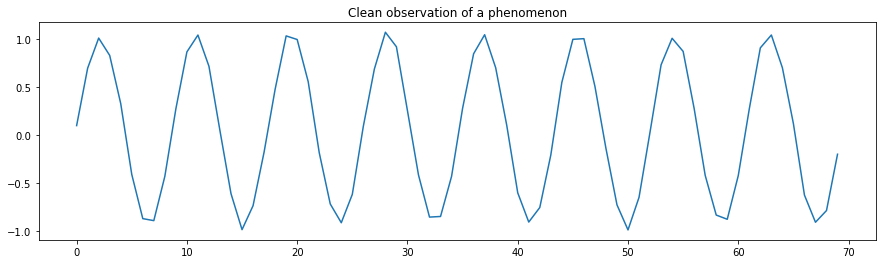

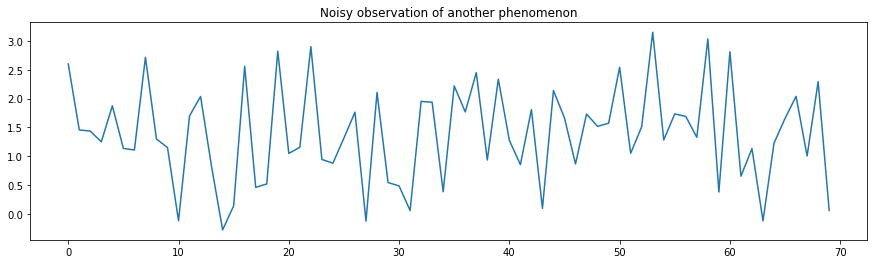

In [38]:
nb_of_observations = 70

t = np.linspace(0,5,nb_of_observations)
rand1 = np.random.rand(len(t)) / 10
rand2 = np.random.rand(len(t))*3
clean_obs = np.sin(10*t) + rand1
noisy_obs = 0.5*np.sin(5*t) + rand2

def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

fig, ax = fig_ax()
plt.title("Clean observation of a phenomenon")
ax.plot([i for i in range(len(clean_obs))], clean_obs)

fig, ax = fig_ax()
plt.title("Noisy observation of another phenomenon")
ax.plot([i for i in range(len(noisy_obs))], noisy_obs)

ADF Statistic: -10.358978365159777
p-value: 2.4244077651363434e-18


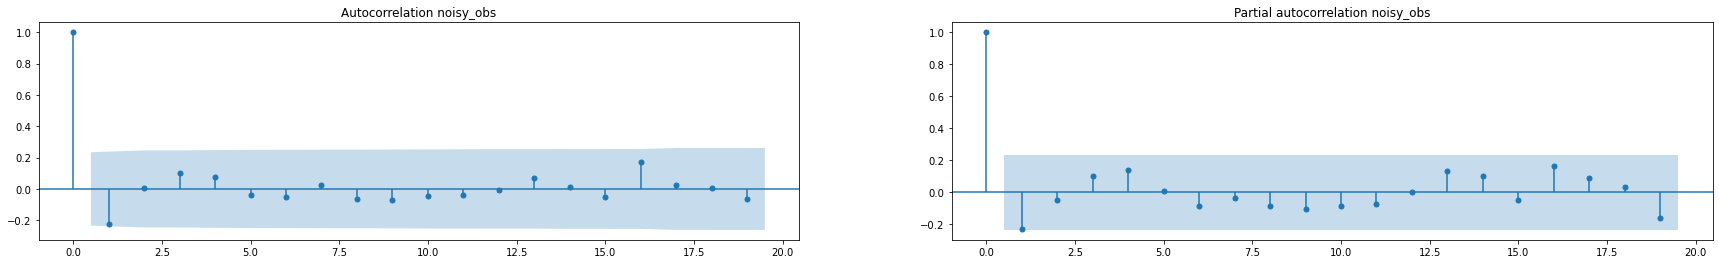

In [39]:
# Fitting ARIMA

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(30, 4))
_ = plot_acf(noisy_obs, ax=ax_0, title="Autocorrelation noisy_obs")
_ = plot_pacf(noisy_obs, ax=ax_1, title="Partial autocorrelation noisy_obs")


##see if noisy_obs is stationary
ad_fuller_result = adfuller(noisy_obs)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 8)   Log Likelihood                 -62.187
Date:                           Thu, 01 Apr 2021   AIC                            128.374
Time:                                   00:32:40   BIC                            131.367
Sample:                                        0   HQIC                           129.381
                                            - 42                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L8       -0.7187      0.159     -4.522      0.000      -1.030      -0.407
sigma2         2.1273      0.517      4.112

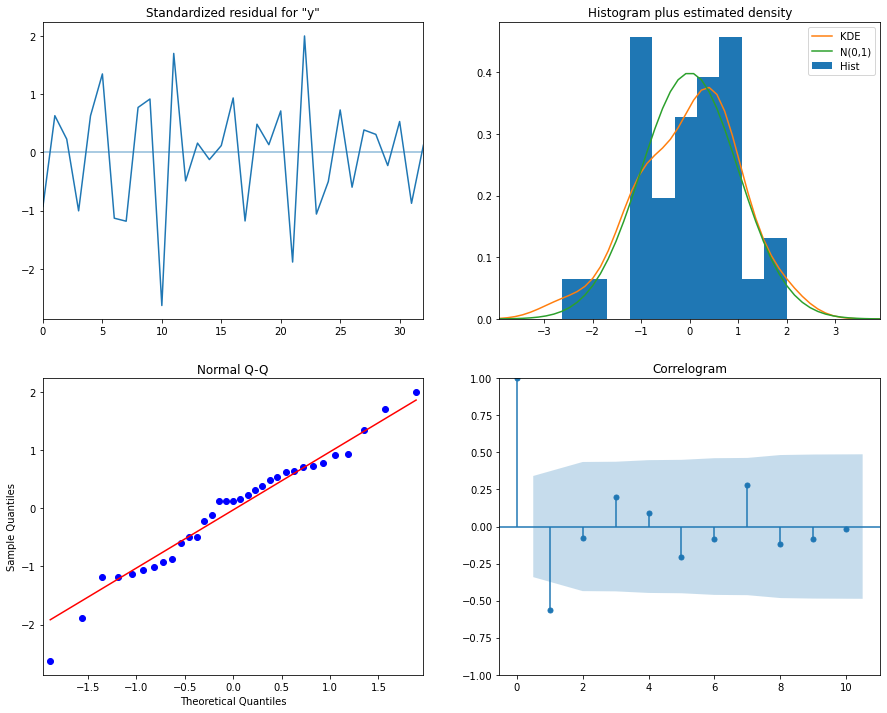

In [40]:
max_autocor = 8

training = noisy_obs[max_autocor:-20]
arima_model = SARIMAX(training, order=(0, 1, 0), seasonal_order=(1, 1, 0, max_autocor)).fit()
print(arima_model.summary())

arima_model.plot_diagnostics(figsize=(15,12));

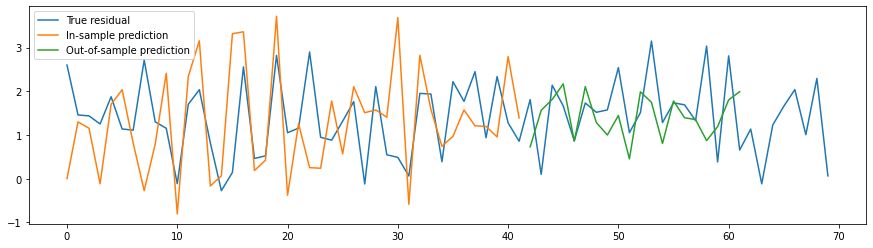

In [41]:
SCOPE = 20

in_sample_pred = arima_model.predict()
out_sample_pred = arima_model.forecast(SCOPE)

fig, ax = fig_ax()
ax.plot([i for i in range(len(noisy_obs))], noisy_obs, label="True residual")
ax.plot([i for i in range(len(training))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(training),len(training)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

C:\Users\Antoine\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


ADF Statistic: -2.3859232923561735
p-value: 0.145748934925167


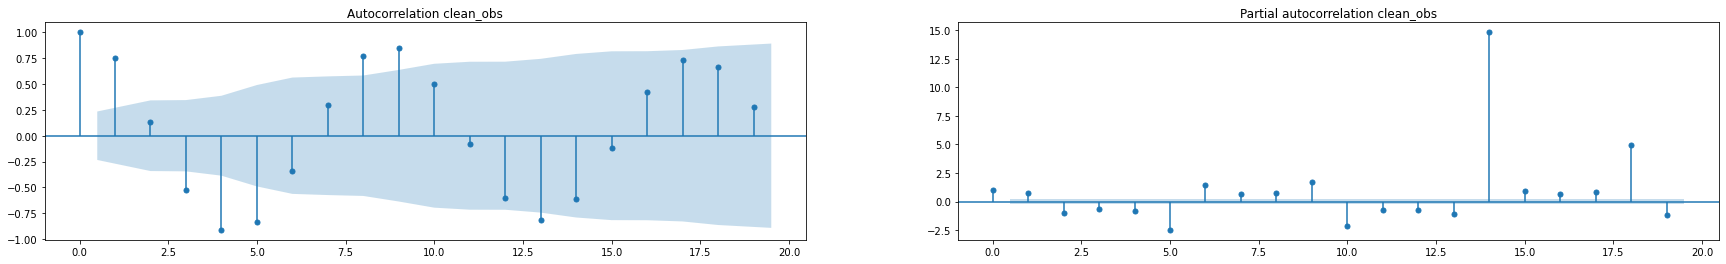

In [43]:
# Fitting arimax model

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(30, 4))
_ = plot_acf(clean_obs, ax=ax_0, title="Autocorrelation clean_obs")
_ = plot_pacf(clean_obs, ax=ax_1, title="Partial autocorrelation clean_obs")


##see if noisy_obs is stationary
ad_fuller_result = adfuller(clean_obs)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   45
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 5)   Log Likelihood                 -28.404
Date:                           Thu, 01 Apr 2021   AIC                             60.807
Time:                                   00:32:58   BIC                             64.134
Sample:                                        0   HQIC                            62.001
                                            - 45                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.8849      0.096     -9.244      0.000      -1.073      -0.697
sigma2         0.2065      0.089      2.314

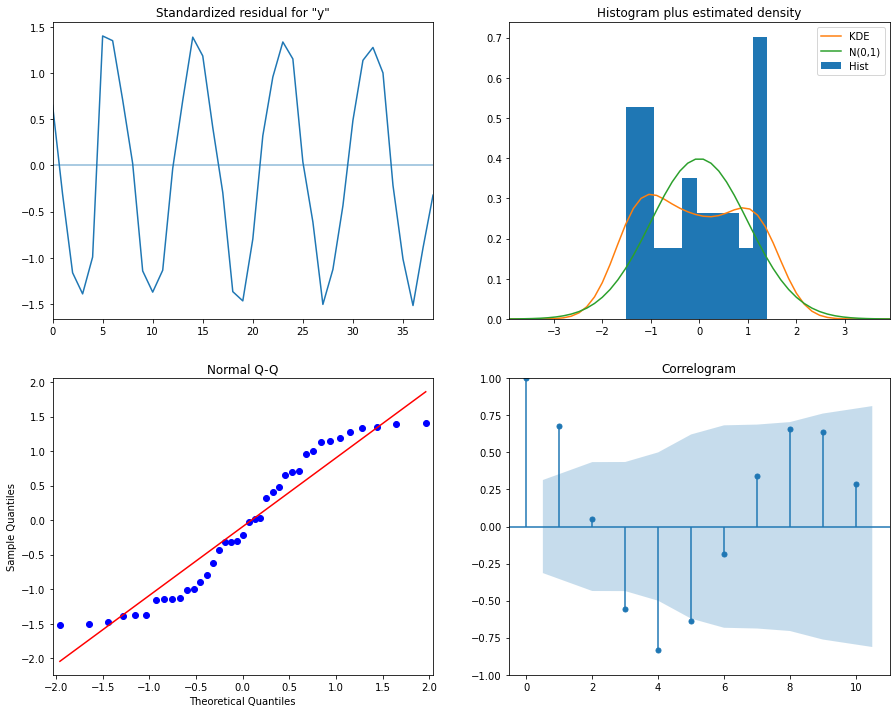

In [44]:
max_autocor = 5

training = clean_obs[max_autocor:-20]
article_model = SARIMAX(training, order=(0, 1, 0), seasonal_order=(1, 1, 0, max_autocor)).fit()
article_model.plot_diagnostics(figsize=(15,12))
print(article_model.summary())

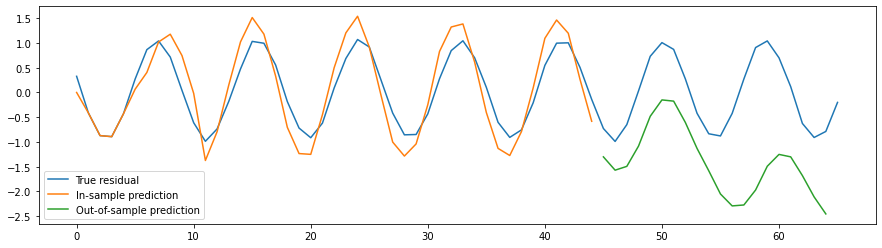

In [50]:
max_autocor = 5

in_sample_pred = article_model.predict()
out_sample_pred = article_model.forecast(SCOPE)
memory_clean_obs_forecasted = out_sample_pred[:]

fig, ax = fig_ax()
ax.plot([i for i in range(len(clean_obs)-4)], clean_obs[4:], label="True residual")
ax.plot([i for i in range(len(training))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(training),len(training)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   45
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 5)   Log Likelihood                 -55.067
Date:                           Thu, 01 Apr 2021   AIC                            124.133
Time:                                   00:36:58   BIC                            135.778
Sample:                                        0   HQIC                           128.311
                                            - 45                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1268      0.117      1.081      0.280      -0.103       0.357
ar.L1         -0.5283      0.222     -2.380

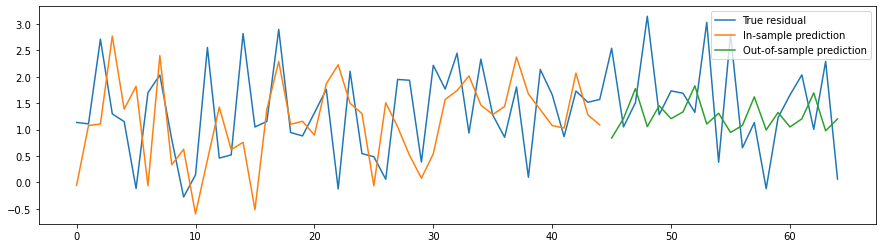

In [51]:
# Transfer function

max_autocor = 5
training_clean = clean_obs[max_autocor:-20]
training_noisy = noisy_obs[max_autocor:-20]

model = SARIMAX(training_noisy, exog = training_clean,order=(2, 1, 1), seasonal_order=(1, 1, 1, max_autocor)).fit()
print(model.summary())

SCOPE = 20

in_sample_pred = model.predict()
out_sample_pred = model.forecast(SCOPE, exog=memory_clean_obs_forecasted)

fig, ax = fig_ax()
ax.plot([i for i in range(len(noisy_obs[max_autocor:]))], noisy_obs[max_autocor:], label="True residual")
ax.plot([i for i in range(len(in_sample_pred))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(in_sample_pred),len(in_sample_pred)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

## Second case : two observations among which one is a hidden state

In this case we will construct a situation in which one of the sequences is a hidden state (that can be intepreted as the state of the market for instance) and the other one is just an observation that depends on this hidden state one step sooner. It will be much easier to derive the observations from the hidden state than from the observation's evolution

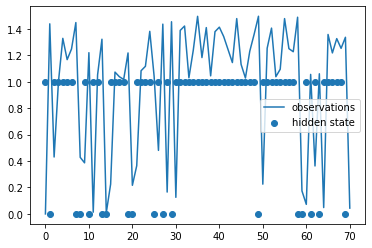

In [29]:
nb_observations = 70

random = np.random.rand(nb_observations)
hidden = (random > 0.3) * 1

observations = np.array([0] + [np.random.rand()/2 + hid for hid in hidden])
plt.plot(observations,label="observations")
plt.scatter([i for i in range(len(hidden))],hidden,label = "hidden state")
plt.legend()
plt.show()

ADF Statistic: -8.667655640173704
p-value: 4.637314050336936e-14


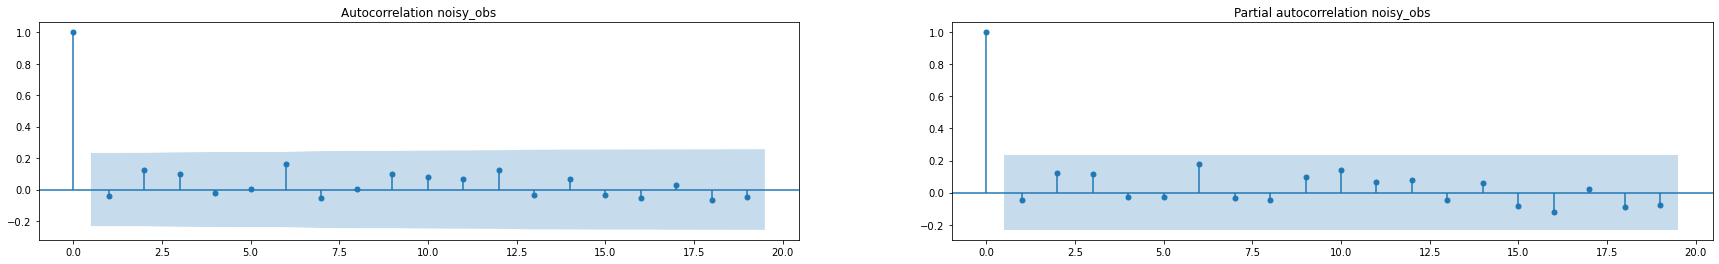

In [30]:
# Fitting ARIMA on observations

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(30, 4))
_ = plot_acf(observations, ax=ax_0, title="Autocorrelation noisy_obs")
_ = plot_pacf(observations, ax=ax_1, title="Partial autocorrelation noisy_obs")


##see if noisy_obs is stationary
ad_fuller_result = adfuller(observations)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   31
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 10)   Log Likelihood                 -26.398
Date:                            Thu, 01 Apr 2021   AIC                             56.796
Time:                                    00:27:30   BIC                             58.788
Sample:                                         0   HQIC                            57.185
                                             - 31                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L10      -0.2676      0.313     -0.855      0.392      -0.881       0.346
sigma2         0.7904      0.370   

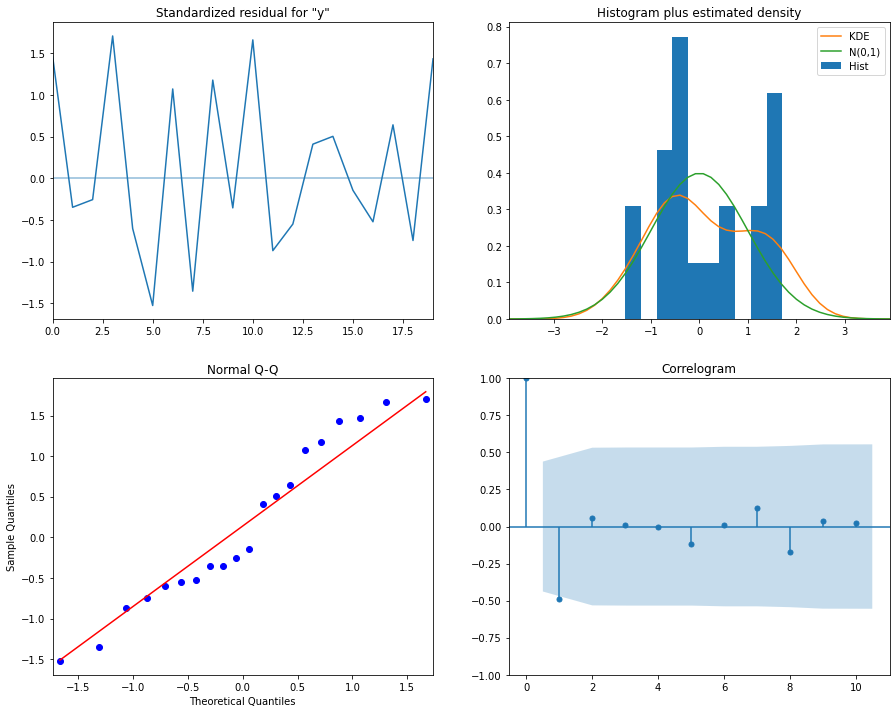

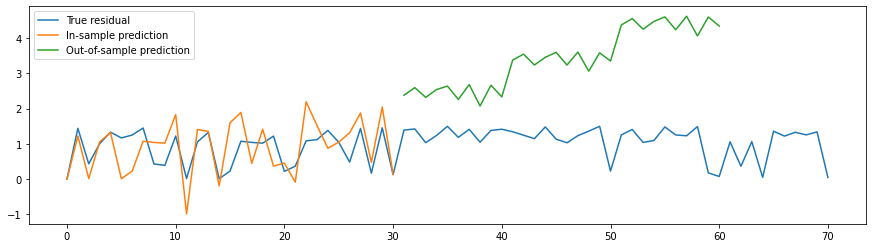

In [31]:
max_autocor = 10
SCOPE = 30

training = observations[max_autocor:-30]
article_model = SARIMAX(training, order=(0, 1, 0), seasonal_order=(1, 1, 0, max_autocor)).fit()
article_model.plot_diagnostics(figsize=(15,12))
print(article_model.summary())

in_sample_pred = article_model.predict()
out_sample_pred = article_model.forecast(SCOPE)
memory_clean_obs_forecasted = out_sample_pred[:]

fig, ax = fig_ax()
ax.plot([i for i in range(len(observations))], observations, label="True residual")
ax.plot([i for i in range(len(training))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(training),len(training)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

ADF Statistic: -7.979219718892461
p-value: 2.6510762495272512e-12


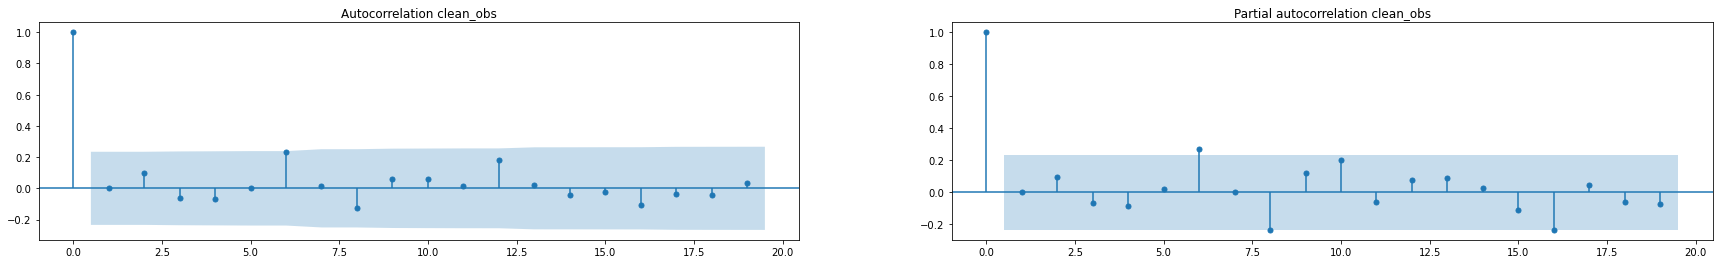

In [33]:
# Fitting Arimax

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(30, 4))
_ = plot_acf(hidden, ax=ax_0, title="Autocorrelation clean_obs")
_ = plot_pacf(hidden, ax=ax_1, title="Partial autocorrelation clean_obs")


##see if noisy_obs is stationary
ad_fuller_result = adfuller(hidden)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   44
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 6)   Log Likelihood                 -35.580
Date:                           Thu, 01 Apr 2021   AIC                             75.159
Time:                                   00:31:57   BIC                             78.381
Sample:                                        0   HQIC                            76.295
                                            - 44                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.3593      0.222     -1.618      0.106      -0.795       0.076
sigma2         0.3918      0.072      5.458

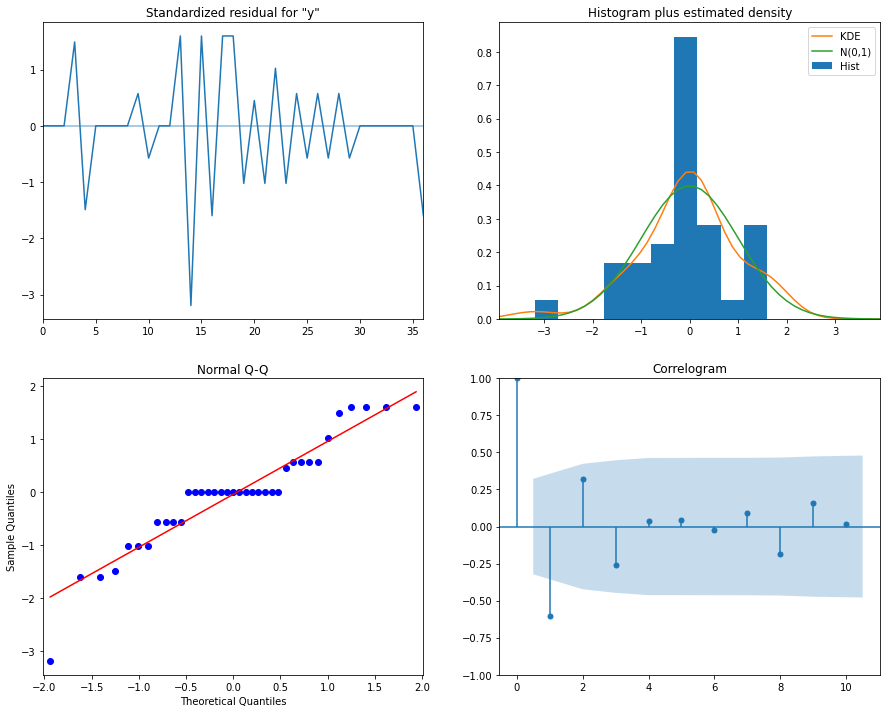

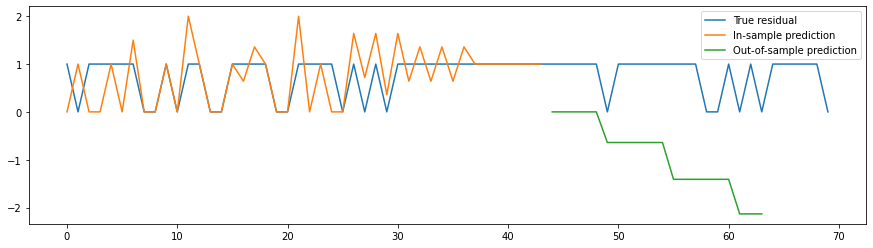

In [36]:
max_autocor = 6
SCOPE = 20

training = hidden[max_autocor:-20]
article_model = SARIMAX(training, order=(0, 1, 0), seasonal_order=(1, 1, 0, max_autocor)).fit()
article_model.plot_diagnostics(figsize=(15,12))
print(article_model.summary())

in_sample_pred = article_model.predict()
out_sample_pred = article_model.forecast(SCOPE)
memory_clean_obs_forecasted = out_sample_pred[:]

fig, ax = fig_ax()
ax.plot([i for i in range(len(hidden))], hidden, label="True residual")
ax.plot([i for i in range(len(training))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(training),len(training)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

In [59]:
len(in_sample_pred)

44

C:\Users\Antoine\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Antoine\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   44
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 -21.910
Date:                           Thu, 01 Apr 2021   AIC                             57.820
Time:                                   00:44:54   BIC                             69.096
Sample:                                        0   HQIC                            61.795
                                            - 44                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1623      0.490     -0.331      0.740      -1.122       0.798
ar.L1          0.0525      0.601      0.087

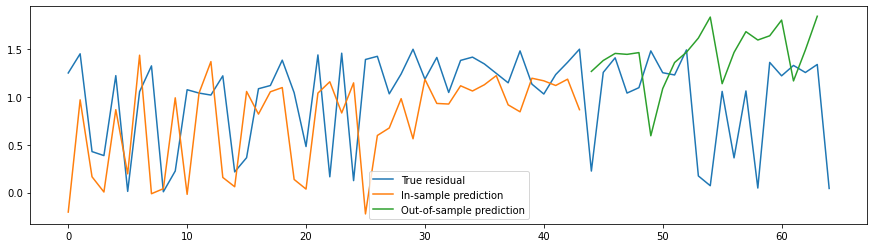

In [61]:
# Transfer function

max_autocor = 6
training_observation = observations[max_autocor:-21]
training_hidden = hidden[max_autocor:-20]

model = SARIMAX(training_hidden, exog = training_observation,order=(2, 1, 1), seasonal_order=(1, 1, 1, max_autocor)).fit()
print(model.summary())

SCOPE = 20

in_sample_pred = model.predict()
out_sample_pred = model.forecast(SCOPE, exog=memory_clean_obs_forecasted)

fig, ax = fig_ax()
ax.plot([i for i in range(len(observations[max_autocor:]))], observations[max_autocor:], label="True residual")
ax.plot([i for i in range(len(in_sample_pred))], in_sample_pred, label="In-sample prediction")
ax.plot([i for i in range(len(in_sample_pred),len(in_sample_pred)+SCOPE)], out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()